# Import Libraries

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time

# Create the Stock Dataframe

In [111]:
from datetime import date

ticker = input("Ticker: ")
start_year = input("Start Year: ")
end_year = input("End Year (T for today): ")

period1 = int(time.mktime(datetime.datetime(int(start_year), 1, 1).timetuple()))

if end_year == "T":
  today = date.today()
  period2 = int(time.mktime(datetime.datetime(today.year, today.month, today.day).timetuple()))
else:
  period2 = int(time.mktime(datetime.datetime(int(end_year), 1, 1).timetuple()))

query_string = f"https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval=1d&events=history&includeAdjustedClose=true"

Ticker: AAPL
Start Year: 2020
End Year (T for today): T


In [112]:
df = pd.read_csv(query_string)
# Only the date and closing price are needed.
df = df[['Date', 'Close']]

In [113]:
from datetime import datetime
df['Date'] = df['Date'].apply(datetime.fromisoformat)

In [114]:
# Turn the date column into the index.
df.index = df.pop('Date')

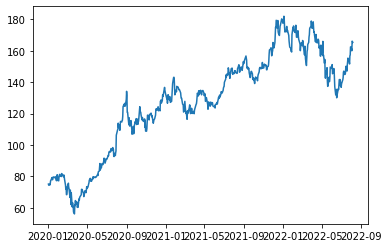

In [115]:
# Plot the data.
plt.plot(df.index, df['Close'])

# Create Windowed Dataframe

In [116]:
import datetime as dt
from datetime import timedelta
# The windowed dataframe will store the previous three days from the target date.
# The previous three days in each index will become the input, and the target will be the output.
# This will allow the dataframe to be used with supervised learning.

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = datetime.fromisoformat(first_date_str) 
  last_date  = datetime.fromisoformat(last_date_str) 

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[ target_date : (target_date + dt.timedelta(days=7)) ]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = dt.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df, '2021-03-25', '2022-03-23')
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,123.389999,122.540001,120.089996,120.589996
1,2021-03-26,122.540001,120.089996,120.589996,121.209999
2,2021-03-29,120.089996,120.589996,121.209999,121.389999
3,2021-03-30,120.589996,121.209999,121.389999,119.900002
4,2021-03-31,121.209999,121.389999,119.900002,122.150002
...,...,...,...,...,...
247,2022-03-17,150.619995,155.089996,159.589996,160.619995
248,2022-03-18,155.089996,159.589996,160.619995,163.979996
249,2022-03-21,159.589996,160.619995,163.979996,165.380005
250,2022-03-22,160.619995,163.979996,165.380005,168.820007


In [117]:
# Convert the windowed dataframe to a TensorFlow object
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  y = df_as_np[:, -1]
  return dates, X.astype(np.float32), y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Train, Validate and Test the Model

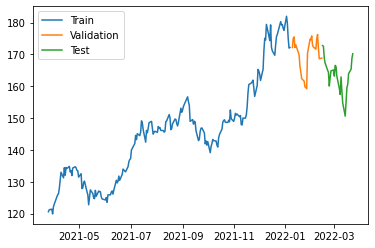

In [118]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [120]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 3s 143ms/step - loss: 21296.6973 - mean_absolute_error: 145.1449 - val_loss: 28716.0918 - val_mean_absolute_error: 169.3710
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 21121.1211 - mean_absolute_error: 144.5395 - val_loss: 28494.7949 - val_mean_absolute_error: 168.7164
Epoch 3/100
7/7 [==============================] - 0s 11ms/step - loss: 20948.6191 - mean_absolute_error: 143.9403 - val_loss: 28315.4746 - val_mean_absolute_error: 168.1842
Epoch 4/100
7/7 [==============================] - 0s 7ms/step - loss: 20792.2793 - mean_absolute_error: 143.3973 - val_loss: 28124.4141 - val_mean_absolute_error: 167.6152
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 20617.8301 - mean_absolute_error: 142.7892 - val_loss: 27903.5879 - val_mean_absolute_error: 166.9551
Epoch 6/100
7/7 [==============================] - 0s 8ms/step - loss: 20410.8613 - mean_absolute_error: 142.0589 - val_loss: 27629.

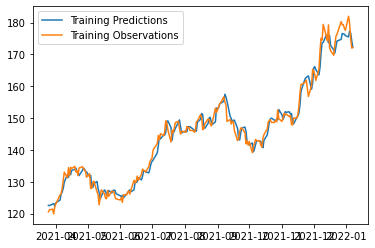

In [121]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

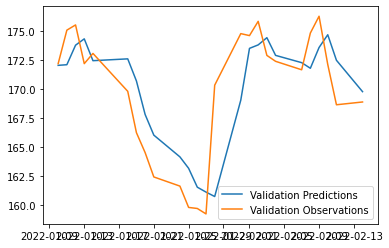

In [122]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

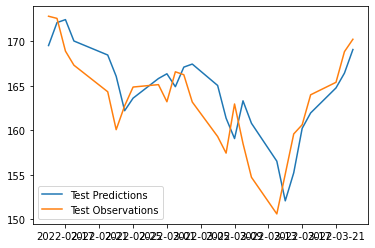

In [123]:
test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Test Predictions', 'Test Observations'])

In [124]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

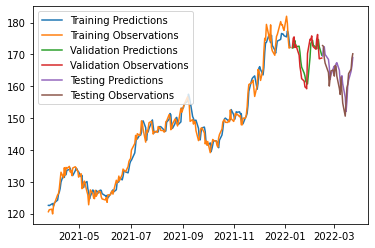

In [125]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])